# 04-09

## Challenge 02 - Electricity Consumption Prediction

---

![](https://images.unsplash.com/photo-1521618755572-156ae0cdd74d?ixlib=rb-1.2.1&ixid=eyJhcHBfaWQiOjEyMDd9&auto=format&fit=crop&w=1656&q=80)
Photo by [Zbynek Burival](https://unsplash.com/photos/V4ZYJZJ3W4M)

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#I.-Key-concepts-in-time-series" data-toc-modified-id="I.-Key-concepts-in-time-series-1">I. Key concepts in time series</a></span></li><li><span><a href="#III.-Decomposition-and-forecasting" data-toc-modified-id="III.-Decomposition-and-forecasting-2">III. Decomposition and forecasting</a></span><ul class="toc-item"><li><span><a href="#1.-Trends" data-toc-modified-id="1.-Trends-2.1">1. Trends</a></span></li><li><span><a href="#2.-Seasonality" data-toc-modified-id="2.-Seasonality-2.2">2. Seasonality</a></span></li><li><span><a href="#3.-Automatic-Decomposition" data-toc-modified-id="3.-Automatic-Decomposition-2.3">3. Automatic Decomposition</a></span></li><li><span><a href="#4.-Model-the-stationary-series" data-toc-modified-id="4.-Model-the-stationary-series-2.4">4. Model the stationary series</a></span><ul class="toc-item"><li><span><a href="#Moving-Average-(MA)-processes" data-toc-modified-id="Moving-Average-(MA)-processes-2.4.1">Moving Average (MA) processes</a></span></li><li><span><a href="#Auto-Regressive-(AR)-processes" data-toc-modified-id="Auto-Regressive-(AR)-processes-2.4.2">Auto Regressive (AR) processes</a></span></li><li><span><a href="#Auto-Regressive-Moving-Average-(ARMA)-processes" data-toc-modified-id="Auto-Regressive-Moving-Average-(ARMA)-processes-2.4.3">Auto Regressive Moving Average (ARMA) processes</a></span></li><li><span><a href="#Auto-Regressive-Integrated-Moving-Average-(ARIMA)-processes" data-toc-modified-id="Auto-Regressive-Integrated-Moving-Average-(ARIMA)-processes-2.4.4">Auto Regressive Integrated Moving Average (ARIMA) processes</a></span></li><li><span><a href="#Seasonal-Autoregressive-Integrated-Moving-Average-(SARIMA)-process" data-toc-modified-id="Seasonal-Autoregressive-Integrated-Moving-Average-(SARIMA)-process-2.4.5">Seasonal Autoregressive Integrated Moving-Average (SARIMA) process</a></span></li><li><span><a href="#Time-series-recomposition" data-toc-modified-id="Time-series-recomposition-2.4.6">Time series recomposition</a></span></li></ul></li><li><span><a href="#5.-Using-Prophet" data-toc-modified-id="5.-Using-Prophet-2.5">5. Using Prophet</a></span></li></ul></li></ul></div>

In this exercise, you will be asked to use insights from the previous exploration, and build forecasts for the electricity consumption.

You will be working with time series of Open Power System Data ([OPSD](https://open-power-system-data.org/)) for Germany. 

The data set includes daily electricity consumption, wind power production, and solar power production between 2006 and 2017. 
```
- Date — The date (yyyy-mm-dd format)
- Consumption — Electricity consumption in GWh
- Wind — Wind power production in GWh
- Solar — Solar power production in GWh
- Wind+Solar — Sum of wind and solar power production in GWh
```

In [1]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import adfuller
from sklearn.linear_model import LinearRegression

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
from IPython.display import Image

In [15]:
# Load file
df = pd.read_csv('opsd_germany_daily.csv', parse_dates=['Date'], index_col='Date', sep =',')
#df = df.dropna()

## I. Key concepts in time series

For what comes next, we will only focus on the consumption (and the prediction of the consumption). 

Q1 - Plot the autocorrelation and partial autocorrelation of the consumption. What do you notice ?

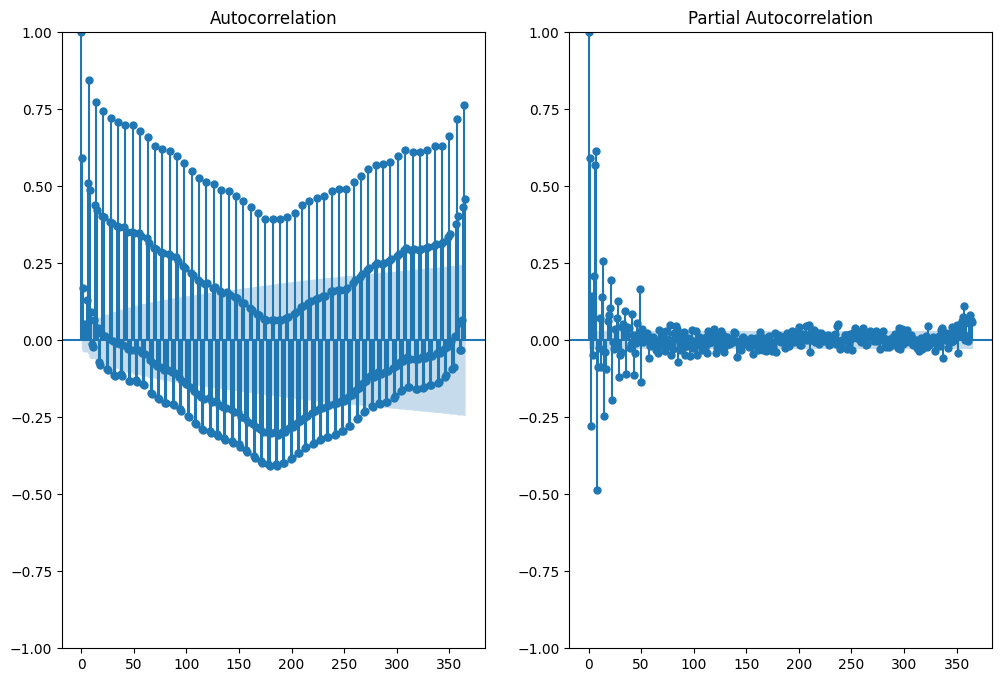

In [16]:
fig, axes = plt.subplots(1,2, figsize=(12,8))
fig = sm.graphics.tsa.plot_acf(df['Consumption'], lags=365, ax=axes[0])
fig = sm.graphics.tsa.plot_pacf(df['Consumption'], lags=365, ax=axes[1])

Q2 - Is the series stationary ? 

In [17]:
# ADFuller 

result = adfuller(df['Consumption'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -6.239148
p-value: 0.000000
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567


Q3 - Can you think of any technique that could help our future model be more precise ?

## III. Decomposition and forecasting

### 1. Trends

Q4 - Try to apply de-trending. Is it interesting ? 

In [3]:
# LinearRegression     
X = np.array(range(len(df['Consumption'])))
y = np.log(df['Consumption']).ffill(axis=0)

lr = LinearRegression().fit(X.reshape(-1,1), y)
pred_lin = lr.predict(X.reshape(-1,1))  

In [4]:
# polyfit & log trend + exp trend
a_1,b_1 = np.polyfit(np.log(X+1), y, 1)
a_2,b_2 = np.polyfit(X+1, np.log(y), 1)

pred_log = a_1 * np.log(X+1) + b_1
pred_exp = np.exp(b_2) + np.exp( (X+1) * a_2)

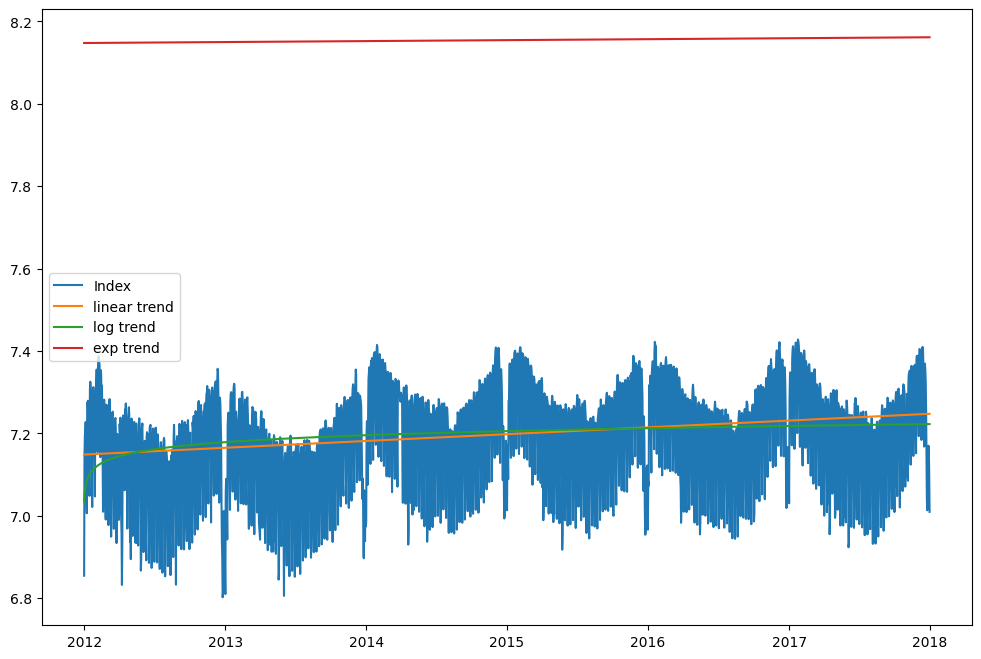

In [5]:
# Plot
plt.figure(figsize=(12,8))
plt.plot(np.log(df['Consumption']), label="Index")
plt.plot(df['Consumption'].index, pred_lin, label="linear trend")
plt.plot(df['Consumption'].index, pred_log, label="log trend")
plt.plot(df['Consumption'].index, pred_exp, label="exp trend")
plt.legend()
plt.show()

We will apply a log transform for what comes next :

In [6]:
data_log = np.log(df)

### 2. Seasonality

Q5 - Try to remove the seasonality. Is it interesting ? 

If we observe some seasonality over a year, the easiest option to remove the trend is to compute the first difference. For example, if there is a yearly seasonality, we can take $ y_t $ - $ y_{t-365} $

In [124]:
from scipy.ndimage.interpolation import shift

In [18]:
# series
series = df['Consumption']

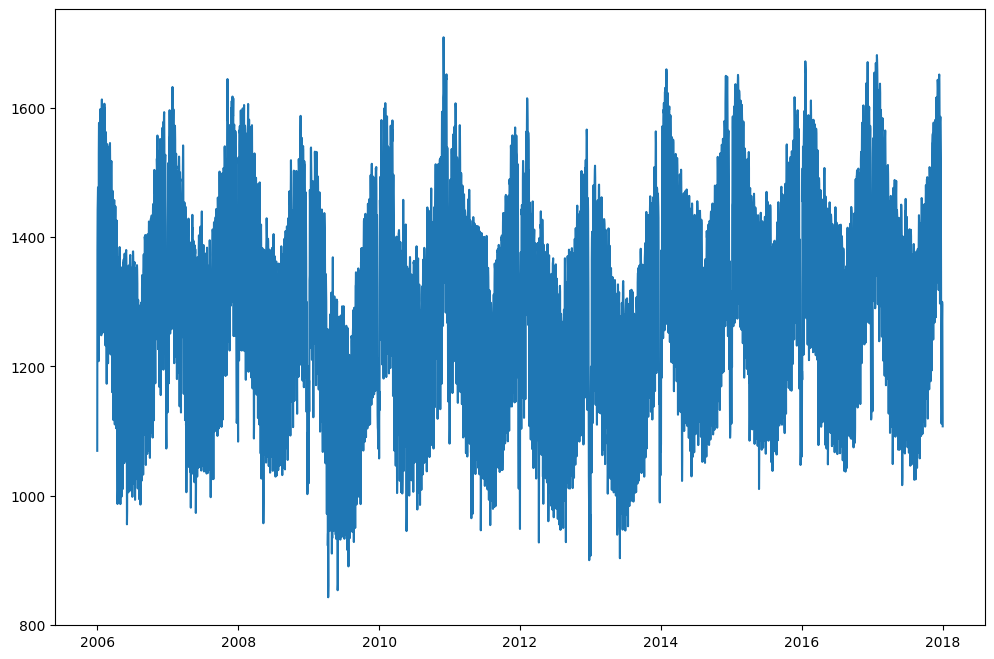

In [19]:
# plot
plt.figure(figsize=(12,8))
plt.plot(series)
plt.show()

Q6 - How does the ADFuller test compare now ? Did you improve anything ?

In [20]:
# ADFuller
result = adfuller(series)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -6.239148
p-value: 0.000000
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567


In [21]:
series_stationary = series - series.shift(365)

result = adfuller(series_stationary.dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -5.150889
p-value: 0.000011
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567


### 3. Automatic Decomposition

Q7 - Does the automatic decomposition of `statsmodels` identify anything else ?

In [23]:
from statsmodels.tsa.seasonal import seasonal_decompose
# decomposition
decomposition = seasonal_decompose(series, period=365)


We set the frequency to 365 in this case since we observe a recurrent pattern over 365 days.

<Figure size 1200x800 with 0 Axes>

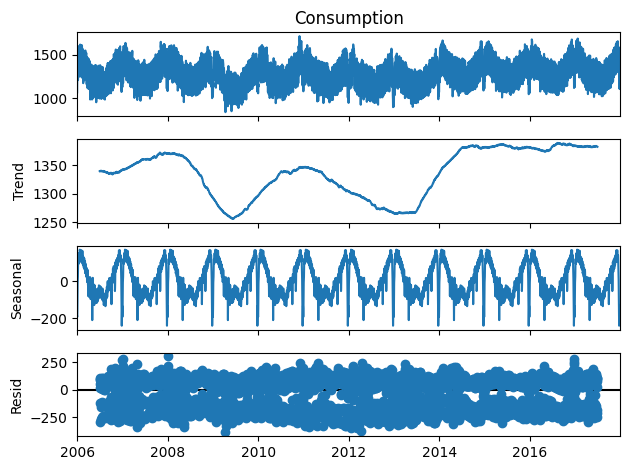

In [24]:
# plot
plt.figure(figsize=(12,8))
decomposition.plot()
plt.show()

### 4. Model the stationary series

Q8 - Taking years of training data is not always the best idea. Based on the decomposition above, what time frame seems the most relevant ?

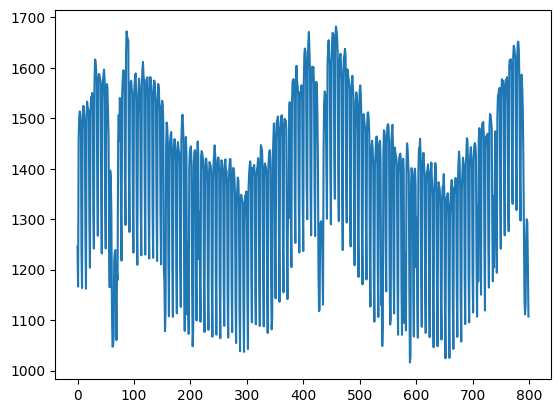

In [26]:
series = series[-800:]
plt.plot(series.values)

#### Moving Average (MA) processes

Q9 - Apply a Moving Average process on 20 % of test data. Comment your results.

In [34]:
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA

# train, test & history
size = int(len(series) * 0.8)
train, test = series[:size], series[size:]
#test = test.reset_index()['Consumption']
history = [x for x in train]
predictions = []


In [35]:
# walk forward over time steps in test
for t in range(int(len(test)*0.2)):
    model = ARIMA(history, order=(0,0,2))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    #obs = test[t]
    history.append(yhat)

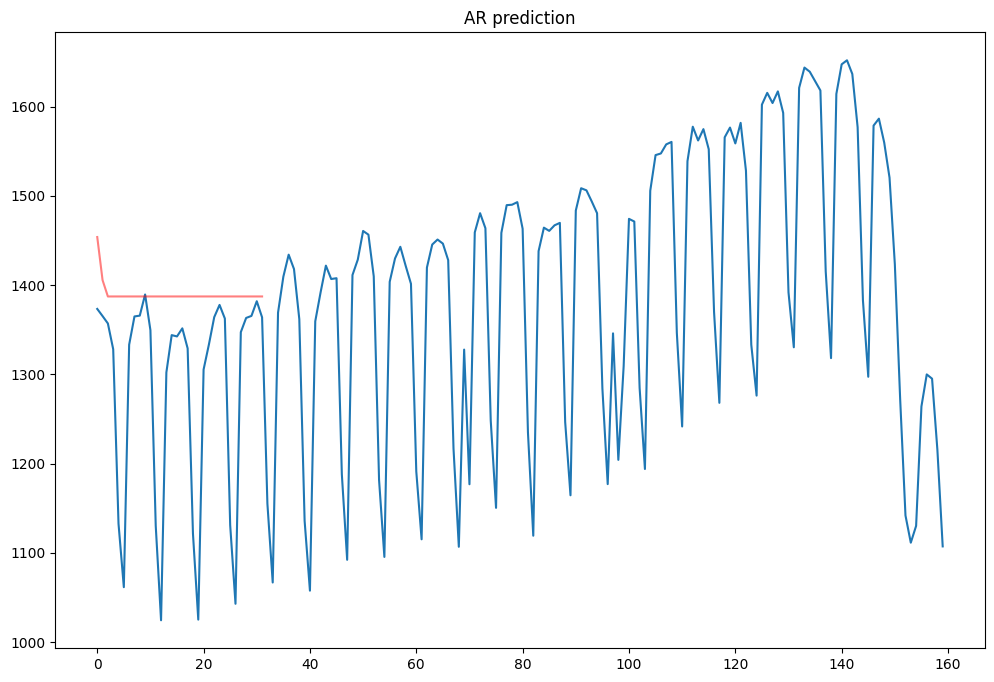

In [36]:
# Plot
plt.figure(figsize=(12,8))
plt.plot(test.values)
plt.title("AR prediction")
plt.plot(predictions, color='red',alpha=0.5)
plt.show()

Zoom on the prediction :

In [ ]:
# Zoom
plt.figure(figsize=(12,8))
plt.plot(test.values[:50])
plt.title("AR prediction")
plt.plot(predictions[:50], color='red',alpha=0.5)
plt.show()

In [141]:
# MSE
len(predictions)
len(test)
mean_squared_error(predictions[:438], test)

0.015363454903171257

#### Auto Regressive (AR) processes

Q10 - Apply an Auto Regressive process on 20 % of test data. Comment your results.

In [143]:
from statsmodels.tsa.ar_model import AutoReg as AR

size = int(len(series) * 0.75)
train, test = series[0:size], series[size:len(series)]
test = test.reset_index()['Consumption']
history = [x for x in train]
predictions = []

for t in range(int(len(test)*0.2)):
    model = ARIMA(history, order=(2,0,0))
    model_fit = model.fit()
    output = model_fit.predict()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(yhat)

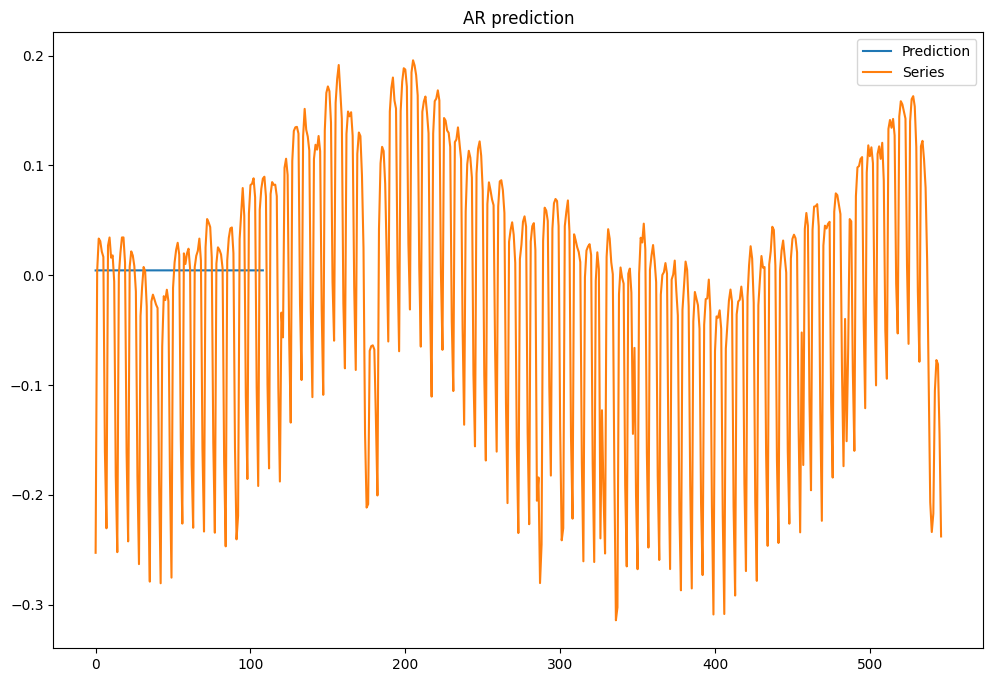

In [144]:
# Plot
plt.figure(figsize=(12,8))
plt.plot(predictions, label="Prediction")
plt.plot(test, label="Series")
plt.title("AR prediction")
plt.legend()
plt.show()

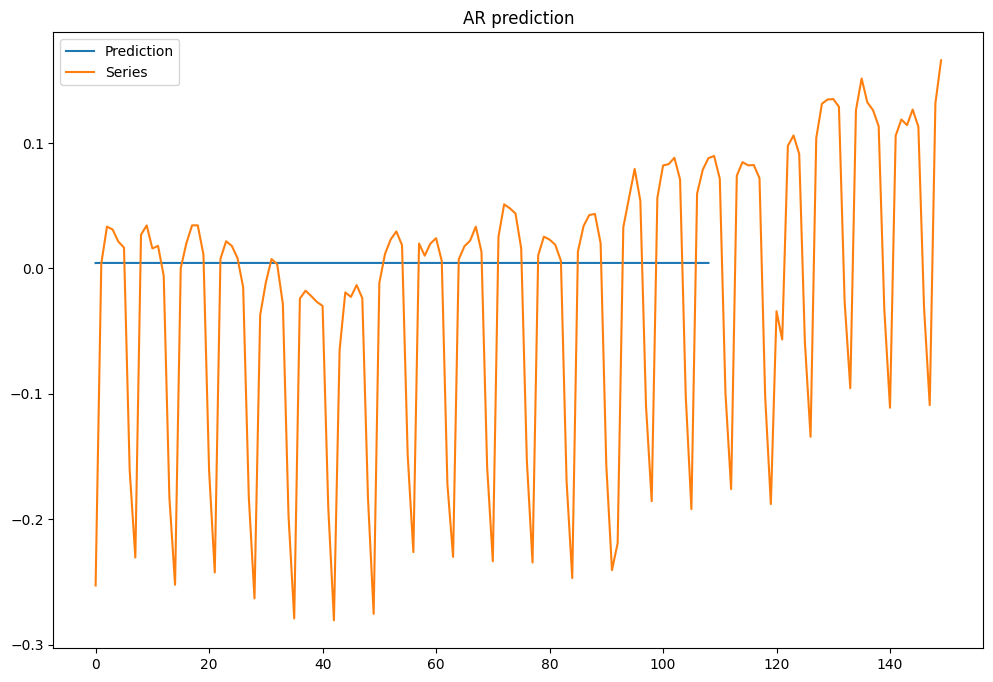

In [145]:
# Zoom
plt.figure(figsize=(12,8))
plt.plot(predictions, label="Prediction")
plt.plot(test[:150], label="Series")
plt.title("AR prediction")
plt.legend()
plt.show()

In [146]:
print(len(predictions))
print(len(test))

109
547


The AR model is not performing well.

In [147]:
# MSE
mean_squared_error(predictions, test[:109])

0.014168930853066324

#### Auto Regressive Moving Average (ARMA) processes

Q11 - Apply an Auto Regressive Moving Average process on 20 % of test data. Comment your results.

In [153]:
size = int(len(series) * 0.75)
train, test = series[0:size], series[size:len(series)]
test = test.reset_index()['Consumption'][:109]
history = [x for x in train]
predictions = []

In [154]:
for t in range(int(len(test)*0.2)):
    model = ARIMA(history, order=(2,0,2)) 
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(yhat)

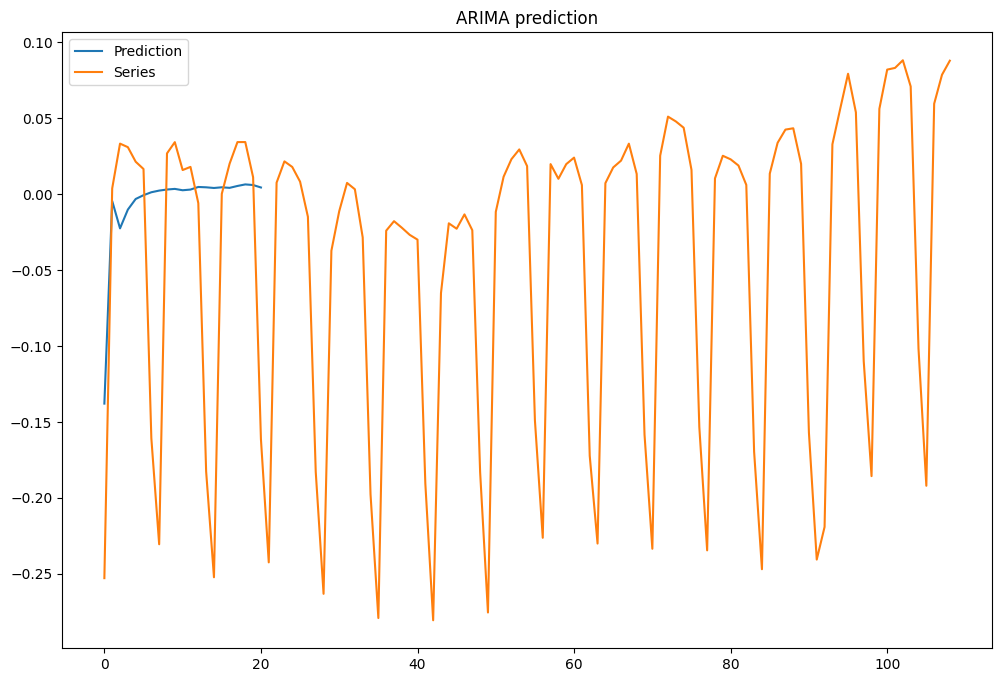

In [155]:
# Plot
plt.figure(figsize=(12,8))
plt.plot(predictions, label="Prediction")
plt.plot(test, label="Series")
plt.title("ARIMA prediction")
plt.legend()
plt.show()

Zoom on the prediction :

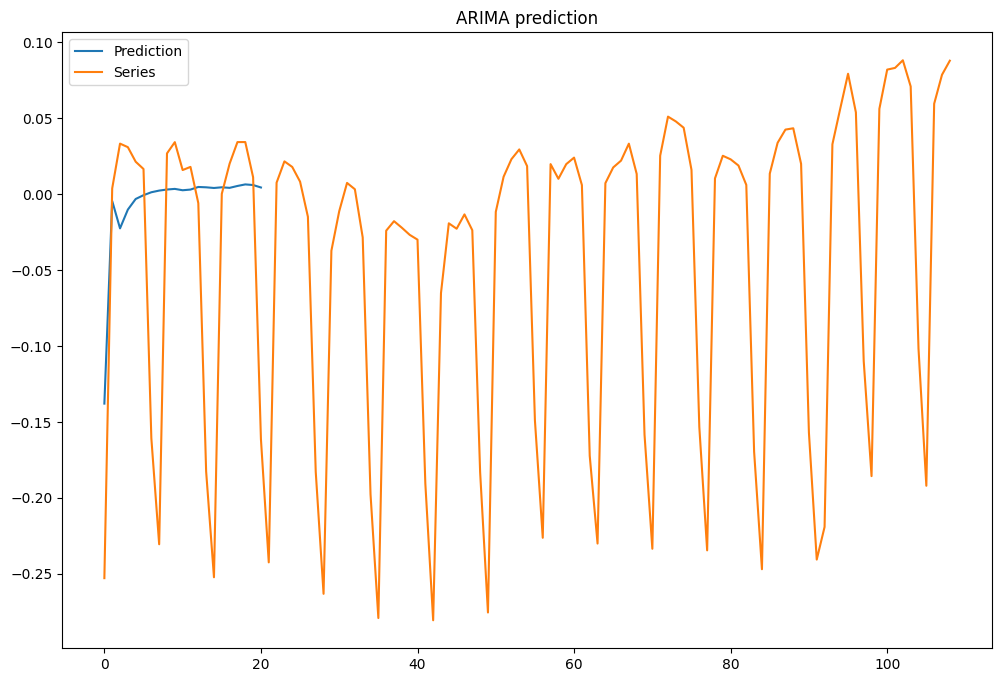

In [156]:
# Zoom
plt.figure(figsize=(12,8))
plt.plot(predictions, label="Prediction")
plt.plot(test[:150], label="Series")
plt.title("ARIMA prediction")
plt.legend()
plt.show()

In [160]:
# MSE
mean_squared_error(predictions, test[:21])

0.011031866290277338

#### Auto Regressive Integrated Moving Average (ARIMA) processes

Q12 - Apply an Auto Regressive Integrated Moving Average process on 5 % of test data. Comment your results.

In [161]:
from statsmodels.tsa.arima.model import ARIMA
size = int(len(series) * 0.75)
train, test = series[0:size], series[size:len(series)]
test = test.reset_index()['Consumption'][:109]
history = [x for x in train]
predictions = []

for t in range(int(len(test)*0.2)):
    model = ARIMA(history, order=(1,1,1))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(yhat)

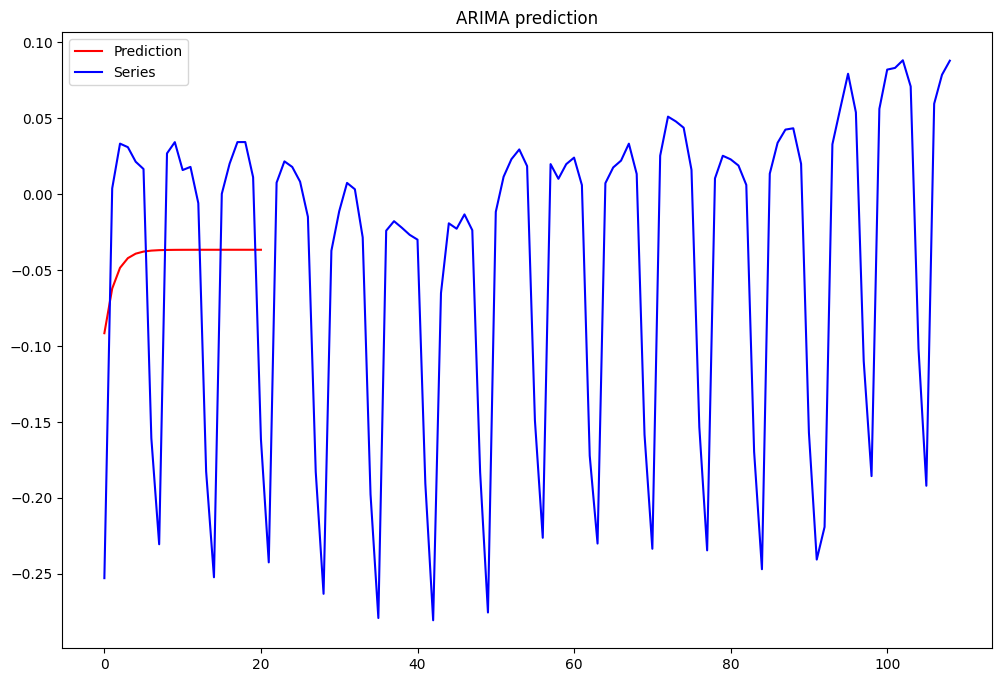

In [162]:
# Plot
plt.figure(figsize=(12,8))
plt.plot(predictions, c='red', label="Prediction")
plt.plot(test, c= 'blue', label="Series")
plt.title("ARIMA prediction")
plt.legend()
plt.show()

Zoom on the prediction :

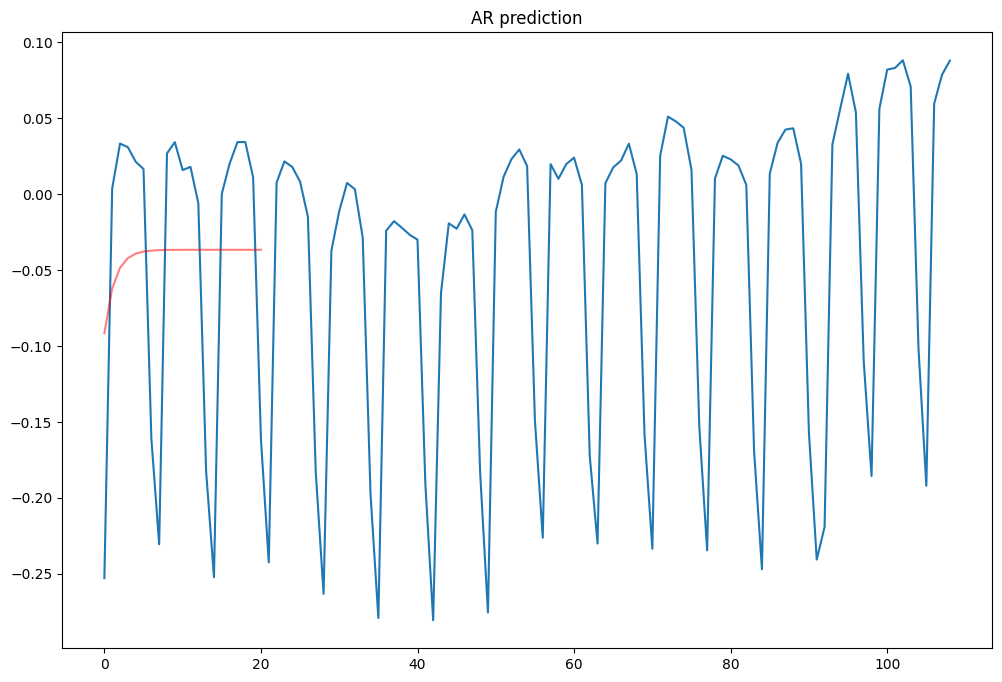

In [163]:
# Zoom
plt.figure(figsize=(12,8))
plt.plot(test[:150])
plt.title("AR prediction")
plt.plot(predictions[:150], color='red',alpha=0.5)
plt.show()

In [165]:
# MSE
mean_squared_error(predictions, test[:21])

0.010376357771299588

#### Seasonal Autoregressive Integrated Moving-Average (SARIMA) process

Q13 - There is a seasonal pattern over time that we cannot remove. SARIMA might help ! Fit and predict with a SARIMA model on 80% of the data.

In [41]:
import warnings
warnings.filterwarnings('ignore')
from statsmodels.tsa.statespace.sarimax import SARIMAX

size = int(len(series) * 0.8)
train, test = series[0:size], series[size:len(series)]
test = test.reset_index()['Consumption']
history = [x for x in train]
predictions = list()

for t in range(len(test)):
    model = SARIMAX(history, order=(1, 1, 1), seasonal_order=(1, 1, 1, 7))
    model_fit = model.fit(disp=False)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(yhat)

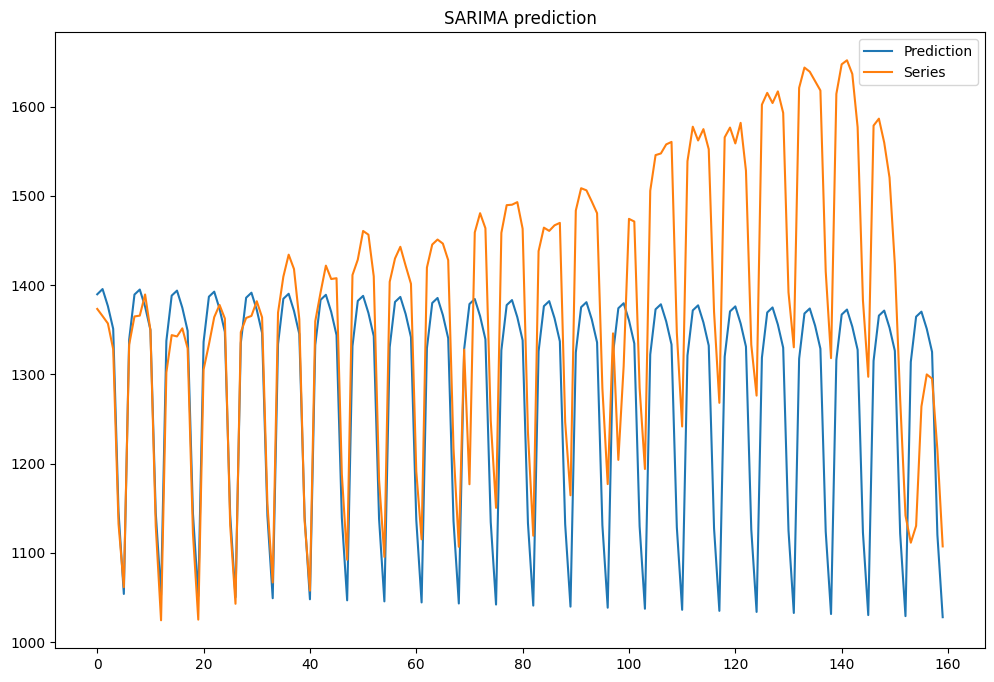

In [42]:
# Plot
plt.figure(figsize=(12,8))
plt.plot(predictions, label="Prediction")
plt.plot(test.values, label="Series")
plt.title("SARIMA prediction")
plt.legend()
plt.show()

Zoom on the prediction :

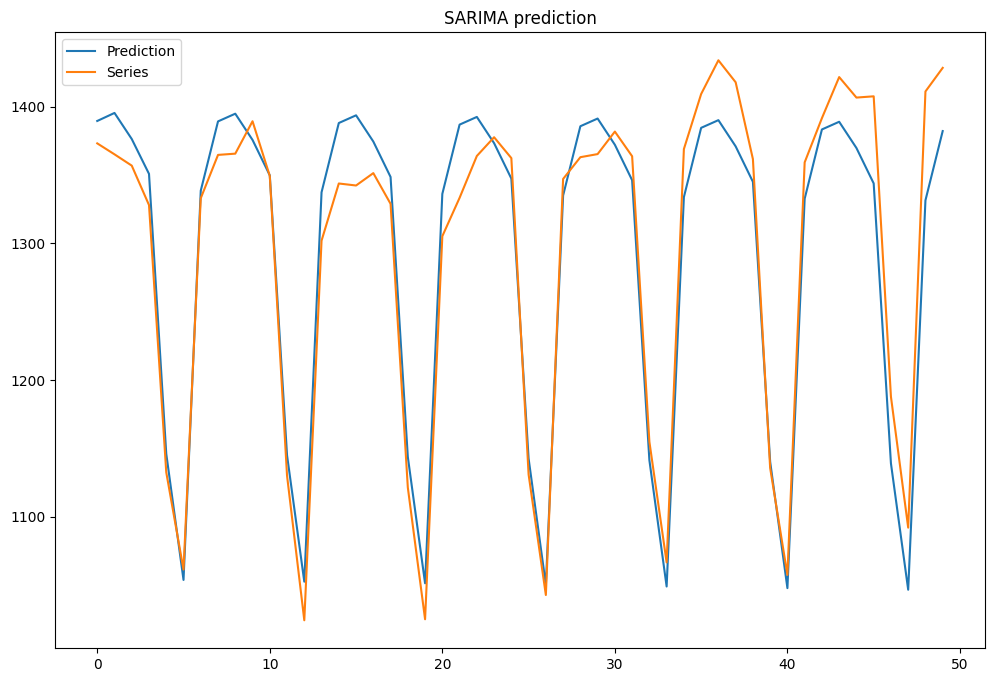

In [43]:
# Zoom
plt.figure(figsize=(12,8))
plt.plot(predictions[:50], label="Prediction")
plt.plot(test[:50], label="Series")
plt.title("SARIMA prediction")
plt.legend()
plt.show()

In [44]:
# MSE
print(len(predictions))
len(test)
mean_squared_error(predictions, test)

160


22071.836516817602

#### Time series recomposition

Q14 - Now that you identified the best model, build the prediction by recomposing the time series !

In [171]:
print(len(train), len(history), len(pred_lin))

1640 1640 2187


In [49]:
history = [x for x in train]

rebuilt_pred = np.concatenate([history, predictions]) + pred_lin[:800] 
rebuilt_ts = np.concatenate([history, test.values]) + pred_lin[:800] 

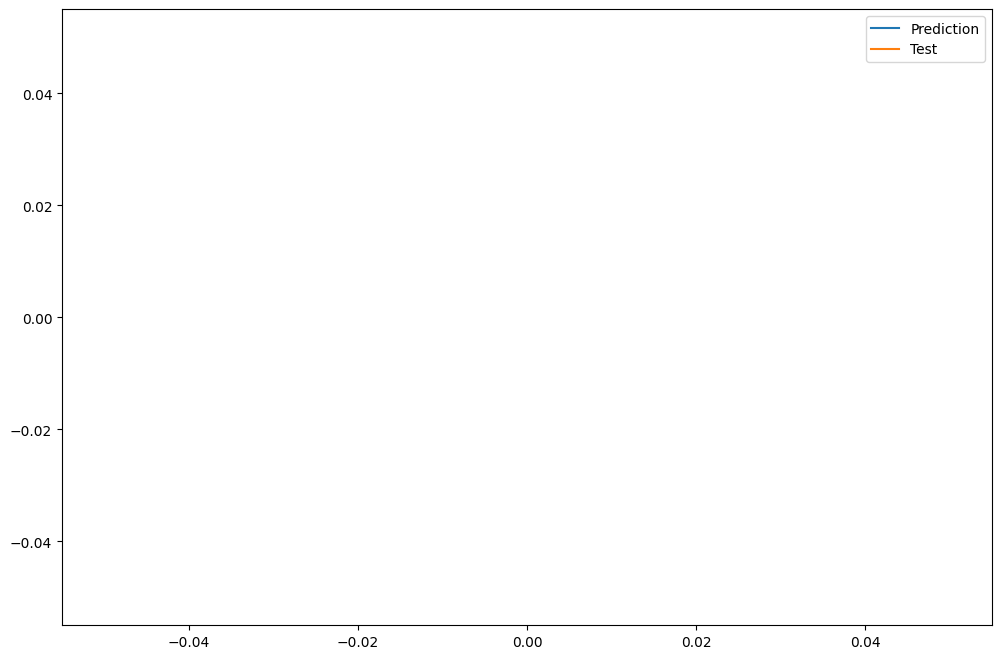

In [48]:
# Plot
plt.figure(figsize=(12,8))
plt.plot(np.exp(rebuilt_pred), label='Prediction')
plt.plot(np.exp(rebuilt_ts), label='Test')
plt.legend()
plt.show()

### 5. Using Prophet

Q15 - Apply a model with Prophet. Comment your results.

In [8]:
from prophet import Prophet
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
df = pd.DataFrame(df['Consumption'].dropna()).reset_index().rename(columns={'Date': 'ds', 'Consumption': 'y'})
df.head()

/Users/awatefbenromdhane/.pyenv/versions/3.10.4/envs/artefact/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


,ds,y
0,2012-01-01,948.128
1,2012-01-02,1269.581
2,2012-01-03,1334.745
3,2012-01-04,1347.136
4,2012-01-05,1376.658


In [9]:
model = Prophet(interval_width=0.95)
model.fit(df)
future = model.make_future_dataframe(periods=36, freq='MS')
forecast = model.predict(future)

17:25:52 - cmdstanpy - INFO - Chain [1] start processing
17:25:53 - cmdstanpy - INFO - Chain [1] done processing


/Users/awatefbenromdhane/.pyenv/versions/3.10.4/envs/artefact/lib/python3.10/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/Users/awatefbenromdhane/.pyenv/versions/3.10.4/envs/artefact/lib/python3.10/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


<Figure size 1800x800 with 0 Axes>

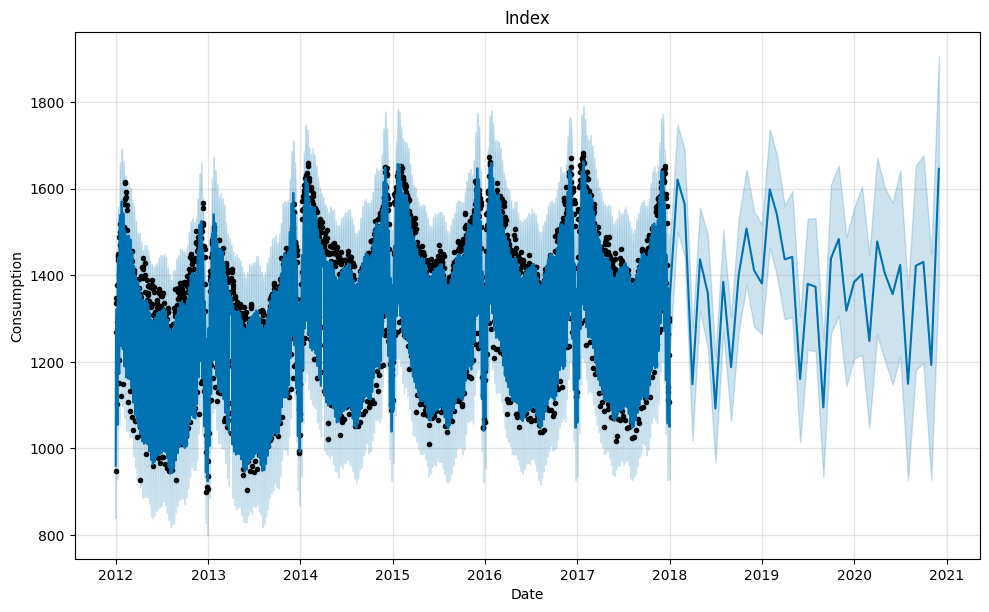

In [10]:
# Plot
plt.figure(figsize=(18, 8))
model.plot(forecast, xlabel = 'Date', ylabel = 'Consumption')
plt.title('Index')
plt.show()

/Users/awatefbenromdhane/.pyenv/versions/3.10.4/envs/artefact/lib/python3.10/site-packages/prophet/plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/Users/awatefbenromdhane/.pyenv/versions/3.10.4/envs/artefact/lib/python3.10/site-packages/prophet/plot.py:351: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  df_y['ds'].dt.to_pydatetime(), seas[name], ls='-', c='#0072B2')
/Users/awatefbenromdhane/.pyenv/versions/3.10.4/envs/artefact/lib/python3.10/site-packages/prophet/plot.py:354: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecat

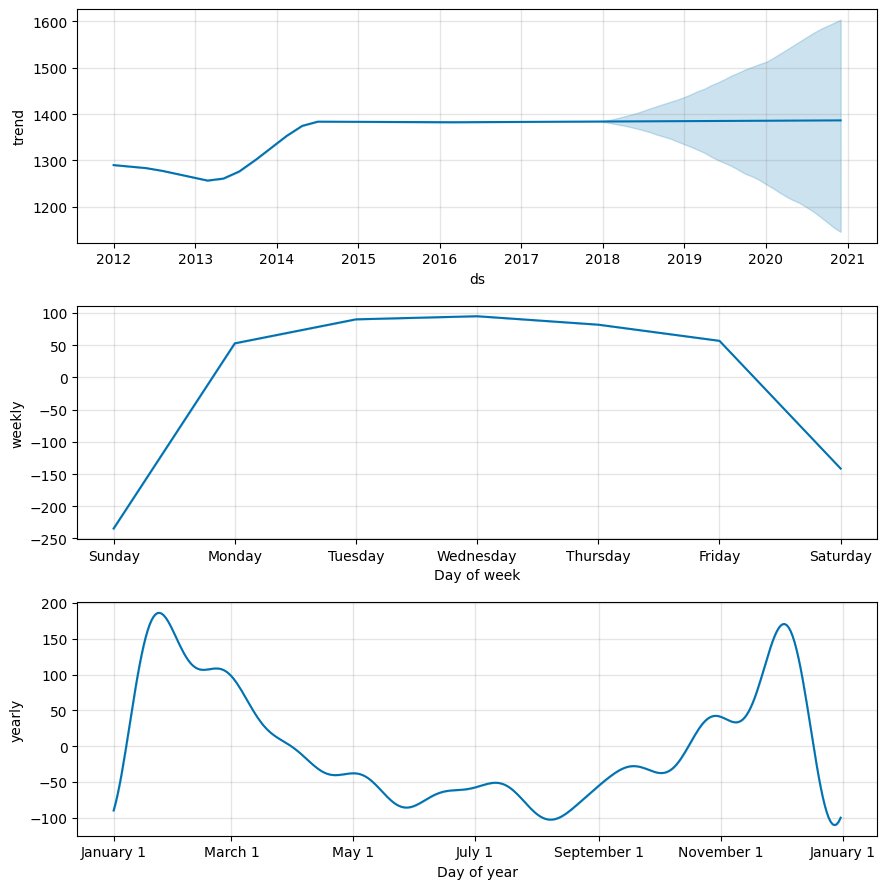

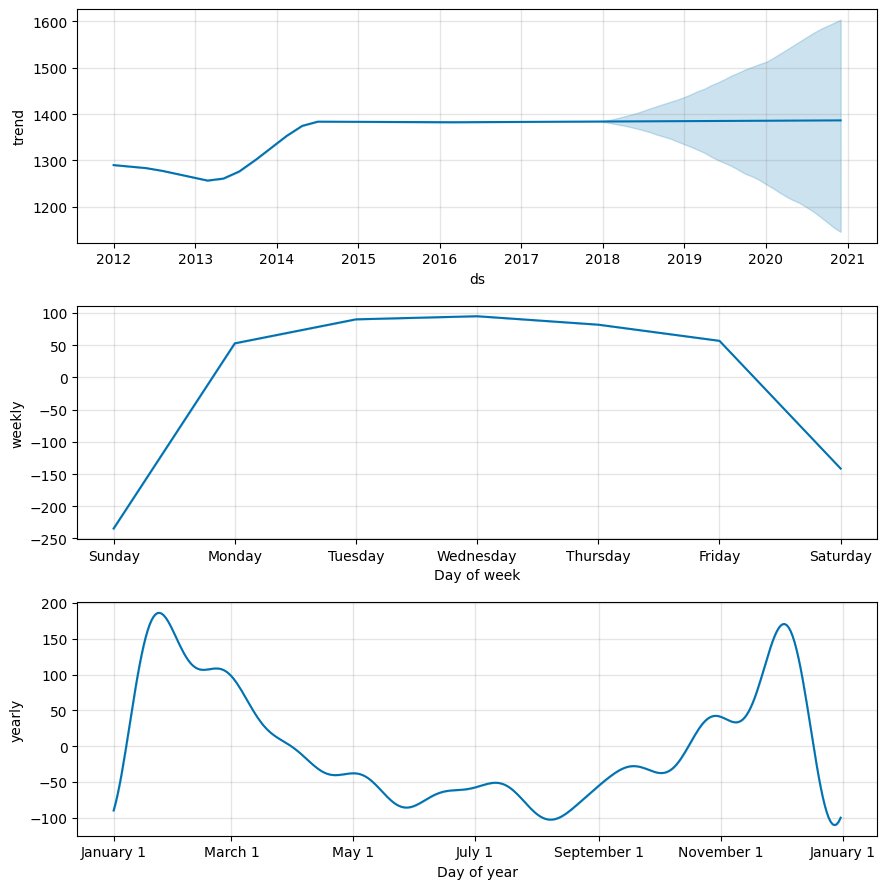

In [11]:
model.plot_components(forecast)